## Explore the tree ring coordinates and assess data quality issues.
- Focus on understanding the coordinate distribution and identifying data problems.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import geopandas as gpd
import json
warnings.filterwarnings('ignore')

In [2]:
# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [3]:
# Load the NOAA entire data from the combined CSV
all_data = pd.read_csv("ring_width_output_new/all_ring_widths_combined.csv")

# Load the original coordinates file for tree ring sites ERA5
coords_df = pd.read_csv("ring_width_output_new/tree_ring_coordinates.csv")

print(f"ERA5 coordinates: {len(coords_df)} sites (unique locations)")
print(f"All NOAA data sites: {all_data['site_code'].nunique()} unique sites")

ERA5 coordinates: 598 sites (unique locations)
All NOAA data sites: 711 unique sites


In [4]:
coords_df.columns

Index(['site_id', 'lat', 'lon', 'elevation_m', 'location', 'year_start',
       'year_end', 'site_code', 'site_name', 'collection_id', 'species_code'],
      dtype='object')

In [5]:
coords_df['location'].unique()

array(['Ontario', 'Nova Scotia', 'Quebec', 'British Columbia', 'Alberta',
       'Manitoba', 'Saskatchewan', 'Newfoundland',
       'Newfoundland and Labrador', 'Newfoundland And Labrador',
       'Yukon Territory', 'Northwest Territories', 'Yukon'], dtype=object)

In [6]:
coords_df

,site_id,lat,lon,elevation_m,location,year_start,year_end,site_code,site_name,collection_id,species_code
0,site_0000,43.066700,-79.266700,185.0,Ontario,1917,2015,CANA636,Pelham,CANA636,ACSH
1,site_0001,43.080222,-79.301492,123.0,Ontario,1856,2024,CAN721,Sulphur Springs Drive,CAN721,TSCA
2,site_0002,43.510000,-79.677222,155.0,Ontario,1892,2018,CANA654; CANA655,Winston Woods (Site 02),CANA654; CANA655,ACSH; QURU
3,site_0003,43.517222,-79.613889,84.0,Ontario,1868,2018,CANA653,Rattray Marsh CA (Site 01),CANA653,TSCA
4,site_0004,43.552778,-79.663611,128.0,Ontario,1897,2018,CANA656; CANA657,UTM A (Site 03),CANA656; CANA657,ACSH; QURU
...,...,...,...,...,...,...,...,...,...,...,...
593,site_0593,68.630000,-138.630000,381.0,Yukon Territory,1570,1977,CANA029,Spruce Creek,CANA029,PCGL
594,site_0594,68.683300,-134.516700,2.0,Northwest Territories,1579,2006,CANA501,Axel Channel Mackenzie Delta,CANA501,PCGL
595,site_0595,68.731700,-133.491700,70.0,Northwest Territories,1881,2014,CANA614,Trail Valley Creek,CANA614,PCMA
596,site_0596,68.783300,-142.350000,NaN,Yukon Territory,1067,2002,CANA315,Firth River Yukon,CANA315,PCGL


Fetch Province shapefile and add to data folder: https://open.canada.ca/data/en/dataset/a883eb14-0c0e-45c4-b8c4-b54c4a819edb

In [7]:
#  Load Canadian provinces shapefile
prov = gpd.read_file("data/lpr_000b16a_e.shp")
if prov.crs is None:
    prov = prov.set_crs(epsg=3347)          # common for this layer
prov = prov.to_crs(epsg=4326)

# Choose a readable province name column
name_col = next(c for c in ["PRENAME", "PRNAME", "ENGLISH_NA", "NAME", "PROV_NAME"] if c in prov.columns)

# Work ONLY on rows where location == "Canada"
mask = coords_df["location"].eq("Canada")
if mask.any():
    # Build points only for the subset
    sub = coords_df.loc[mask, ["lon", "lat"]].copy()
    sub_g = gpd.GeoDataFrame(
        sub,
        geometry=gpd.points_from_xy(sub["lon"], sub["lat"]),
        crs="EPSG:4326"
    )

    # Spatial join just this subset
    hit = gpd.sjoin(sub_g, prov[[name_col, "geometry"]], how="left", predicate="intersects")\
            .rename(columns={name_col: "province"})[["province"]]

    # Optional tiny nearest fallback for any NA (reproject only those)
    na_idx = hit["province"].isna()
    if na_idx.any():
        sub_m = sub_g.loc[na_idx].to_crs(epsg=3347)
        prov_m = prov.to_crs(epsg=3347)
        nearest = gpd.sjoin_nearest(
            sub_m, prov_m[[name_col, "geometry"]], how="left", max_distance=5000
        ).rename(columns={name_col: "province"})[["province"]]
        # bring back to original index
        nearest = nearest.to_crs(epsg=4326)
        hit.loc[na_idx, "province"] = nearest["province"].values

    # Update only the 'Canada' rows in place (keep 'Canada' if still NA)
    coords_df.loc[mask, "location"] = hit["province"].fillna("Canada").values

# Save updated coordinates with provinces
coords_df.to_csv("ring_width_output_new/tree_ring_coordinates.csv", index=False)

In [8]:
coords_df

,site_id,lat,lon,elevation_m,location,year_start,year_end,site_code,site_name,collection_id,species_code
0,site_0000,43.066700,-79.266700,185.0,Ontario,1917,2015,CANA636,Pelham,CANA636,ACSH
1,site_0001,43.080222,-79.301492,123.0,Ontario,1856,2024,CAN721,Sulphur Springs Drive,CAN721,TSCA
2,site_0002,43.510000,-79.677222,155.0,Ontario,1892,2018,CANA654; CANA655,Winston Woods (Site 02),CANA654; CANA655,ACSH; QURU
3,site_0003,43.517222,-79.613889,84.0,Ontario,1868,2018,CANA653,Rattray Marsh CA (Site 01),CANA653,TSCA
4,site_0004,43.552778,-79.663611,128.0,Ontario,1897,2018,CANA656; CANA657,UTM A (Site 03),CANA656; CANA657,ACSH; QURU
...,...,...,...,...,...,...,...,...,...,...,...
593,site_0593,68.630000,-138.630000,381.0,Yukon Territory,1570,1977,CANA029,Spruce Creek,CANA029,PCGL
594,site_0594,68.683300,-134.516700,2.0,Northwest Territories,1579,2006,CANA501,Axel Channel Mackenzie Delta,CANA501,PCGL
595,site_0595,68.731700,-133.491700,70.0,Northwest Territories,1881,2014,CANA614,Trail Valley Creek,CANA614,PCMA
596,site_0596,68.783300,-142.350000,NaN,Yukon Territory,1067,2002,CANA315,Firth River Yukon,CANA315,PCGL


In [9]:
coords_df['location'].unique()

array(['Ontario', 'Nova Scotia', 'Quebec', 'British Columbia', 'Alberta',
       'Manitoba', 'Saskatchewan', 'Newfoundland',
       'Newfoundland and Labrador', 'Newfoundland And Labrador',
       'Yukon Territory', 'Northwest Territories', 'Yukon'], dtype=object)

In [10]:
summary_file = "ring_width_output_new/extraction_summary.json"

with open(summary_file, 'r') as f:
    summary_data = json.load(f)
    print(f"Loaded summary data")

Loaded summary data


### Looking at tree ring coordinates and data quality. Needed to get climate data.

In [11]:
print(f"\nCOORDINATE DATA EXPLORATION")
print(f"Total unique coordinate pairs: {len(coords_df)}")
print(f"Columns: {list(coords_df.columns)}")

print(f"\nGEOGRAPHIC DISTRIBUTION:")
print(f"Latitude range: {coords_df['lat'].min():.6f} to {coords_df['lat'].max():.6f}")
print(f"Longitude range: {coords_df['lon'].min():.6f} to {coords_df['lon'].max():.6f}")

if 'location' in coords_df.columns:
            print(f"\nSITES BY PROVINCE:")
            province_counts = coords_df['location'].value_counts()
            for province, count in province_counts.items():
                print(f"  {province}: {count}")
                
if 'elevation_m' in coords_df.columns:
    elevation_data = pd.to_numeric(coords_df['elevation_m'], errors='coerce')
    valid_elevations = elevation_data.dropna()
    if len(valid_elevations) > 0:
        print(f"\nELEVATION STATISTICS:")
        print(f"  Valid elevation records: {len(valid_elevations)}/{len(coords_df)}")
        print(f"  Range: {valid_elevations.min():.0f} - {valid_elevations.max():.0f} m")
        print(f"  Mean: {valid_elevations.mean():.0f} m")
        print(f"  Median: {valid_elevations.median():.0f} m")
        
# Time range distribution
if 'year_start' in coords_df.columns and 'year_end' in coords_df.columns:
    year_start = pd.to_numeric(coords_df['year_start'], errors='coerce')
    year_end = pd.to_numeric(coords_df['year_end'], errors='coerce')
    
    print(f"\nTIME RANGE STATISTICS:")
    print(f"  Earliest start year: {year_start.min():.0f}")
    print(f"  Latest end year: {year_end.max():.0f}")
    print(f"  Average time span: {(year_end - year_start).mean():.0f} years")

# Species distribution
if 'species_code' in coords_df.columns:
    print(f"\nSPECIES DISTRIBUTION (top 10):")
    # Handle multiple species per site
    all_species = []
    for species_str in coords_df['species_code'].dropna():
        species_list = [s.strip() for s in str(species_str).split(';')]
        all_species.extend(species_list)
    
    species_counts = pd.Series(all_species).value_counts()
    for species, count in species_counts.head(10).items():
        print(f"  {species}: {count} sites")


COORDINATE DATA EXPLORATION
Total unique coordinate pairs: 598
Columns: ['site_id', 'lat', 'lon', 'elevation_m', 'location', 'year_start', 'year_end', 'site_code', 'site_name', 'collection_id', 'species_code']

GEOGRAPHIC DISTRIBUTION:
Latitude range: 43.066700 to 69.500000
Longitude range: -142.350000 to -58.670000

SITES BY PROVINCE:
  British Columbia: 149
  Alberta: 96
  Ontario: 77
  Northwest Territories: 74
  Yukon Territory: 71
  Quebec: 60
  Manitoba: 32
  Saskatchewan: 23
  Newfoundland and Labrador: 7
  Newfoundland: 6
  Nova Scotia: 1
  Newfoundland And Labrador: 1
  Yukon: 1

ELEVATION STATISTICS:
  Valid elevation records: 559/598
  Range: 2 - 2350 m
  Mean: 826 m
  Median: 531 m

TIME RANGE STATISTICS:
  Earliest start year: -1863
  Latest end year: 2024
  Average time span: 353 years

SPECIES DISTRIBUTION (top 10):
  PCGL: 162 sites
  PCEN: 61 sites
  PCMA: 50 sites
  ABLA: 43 sites
  PSME: 41 sites
  TSME: 33 sites
  LALA: 30 sites
  ACSH: 29 sites
  PIBN: 29 sites
  

In [12]:
# looking at entire cleaned dataset 
clean_file = all_data.copy()


print(f"\nDATA QUALITY ASSESSMENT")
print("-" * 50)

# Basic stats with missing value handling
print(f"Sample size: {len(clean_file)} measurements")
print(f"Unique sites: {clean_file['site_code'].dropna().nunique()}")
print(f"Unique trees: {clean_file['tree_id'].dropna().nunique()}")

# Check for missing values
print(f"Missing site codes: {clean_file['site_code'].isna().sum()}")
print(f"Missing tree IDs: {clean_file['tree_id'].isna().sum()}")


# Year range issues
print(f"\nYEAR RANGE ANALYSIS:")
year_stats = clean_file['year'].describe()
print(f"  Min year: {year_stats['min']}")
print(f"  Max year: {year_stats['max']}")
print(f"  Mean year: {year_stats['mean']:.0f}")
print(f"  Median year: {year_stats['50%']:.0f}")

# Identify problematic years
negative_years = clean_file[clean_file['year'] < 0]
future_years = clean_file[clean_file['year'] > 2025]
ancient_years = clean_file[clean_file['year'] < 1000]

print(f"\nPROBLEMATIC YEARS:")
print(f"  Negative years: {len(negative_years)} measurements")
print(f"  Future years (>2025): {len(future_years)} measurements") 
print(f"  Ancient years (<1000): {len(ancient_years)} measurements")

if len(negative_years) > 0:
    print(f"  Negative year range: {negative_years['year'].min()} to {negative_years['year'].max()}")
if len(future_years) > 0:
    print(f"  Future year range: {future_years['year'].min()} to {future_years['year'].max()}")

# Ring width analysis
print(f"\nRING WIDTH ANALYSIS:")
width_stats = clean_file['ring_width_mm'].describe()
print(f"  Min width: {width_stats['min']:.3f} mm")
print(f"  Max width: {width_stats['max']:.3f} mm") 
print(f"  Mean width: {width_stats['mean']:.3f} mm")
print(f"  Median width: {width_stats['50%']:.3f} mm")

# Identify extreme ring widths
zero_widths = clean_file[clean_file['ring_width_mm'] <= 0]
huge_widths = clean_file[clean_file['ring_width_mm'] > 10]

print(f"\nEXTREME RING WIDTHS:")
print(f"  Zero/negative widths: {len(zero_widths)} measurements")
print(f"  Extremely large (>10mm): {len(huge_widths)} measurements")

# File type distribution
if 'file_type' in clean_file.columns:
    print(f"\nFILE TYPE DISTRIBUTION:")
    file_types = clean_file['file_type'].value_counts()
    for ftype, count in file_types.items():
        print(f"  {ftype}: {count}")


DATA QUALITY ASSESSMENT
--------------------------------------------------
Sample size: 8498039 measurements
Unique sites: 711
Unique trees: 33111
Missing site codes: 0
Missing tree IDs: 0

YEAR RANGE ANALYSIS:
  Min year: 800.0
  Max year: 2024.0
  Mean year: 1811
  Median year: 1873

PROBLEMATIC YEARS:
  Negative years: 0 measurements
  Future years (>2025): 0 measurements
  Ancient years (<1000): 198476 measurements

RING WIDTH ANALYSIS:
  Min width: 0.001 mm
  Max width: 15.000 mm
  Mean width: 0.703 mm
  Median width: 0.008 mm

EXTREME RING WIDTHS:
  Zero/negative widths: 0 measurements
  Extremely large (>10mm): 92716 measurements


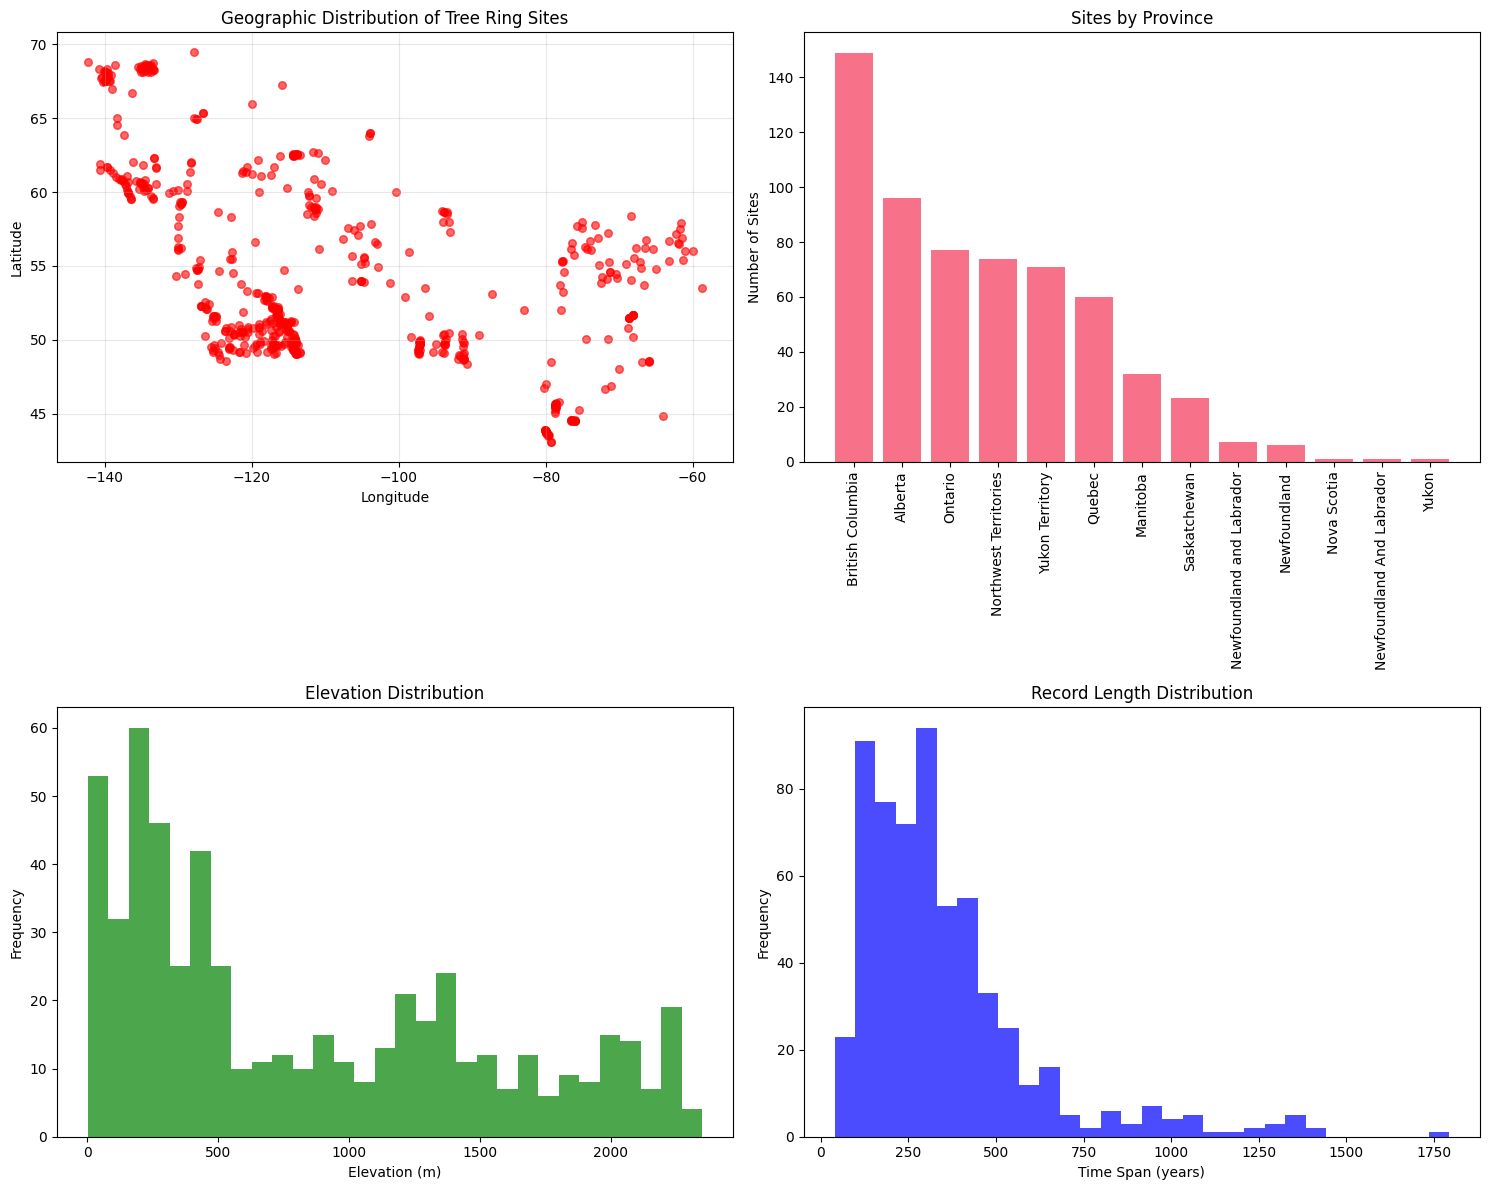

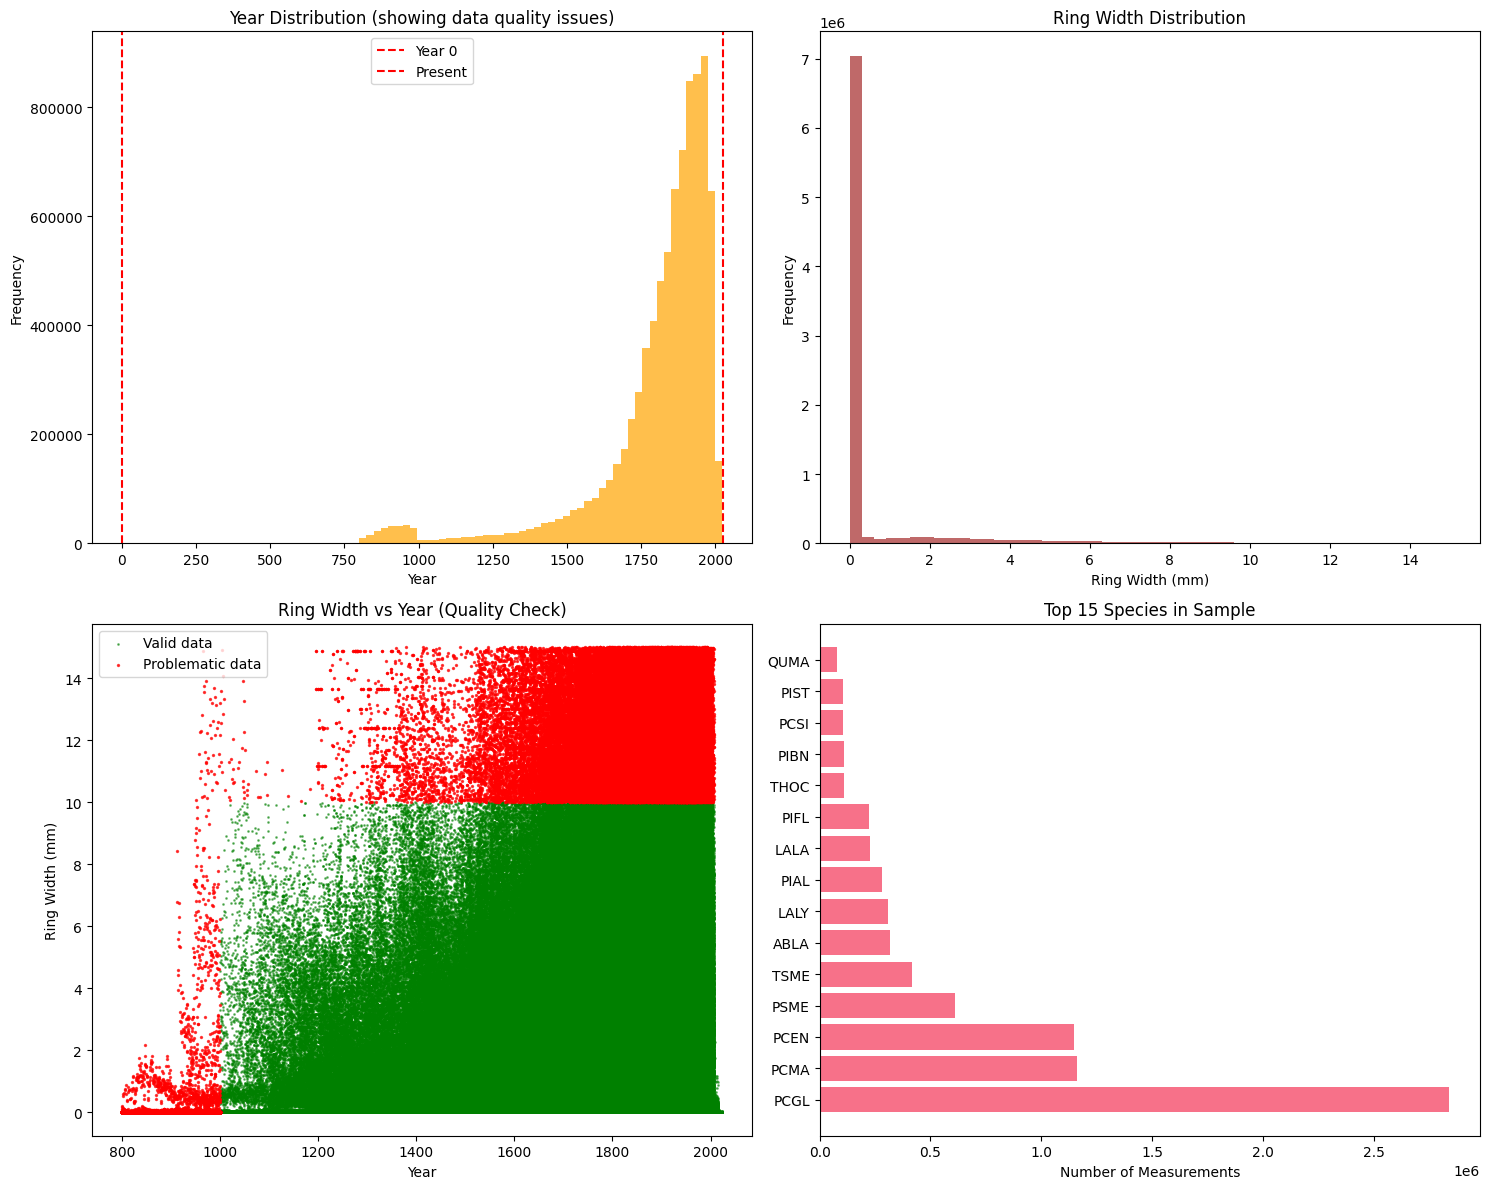

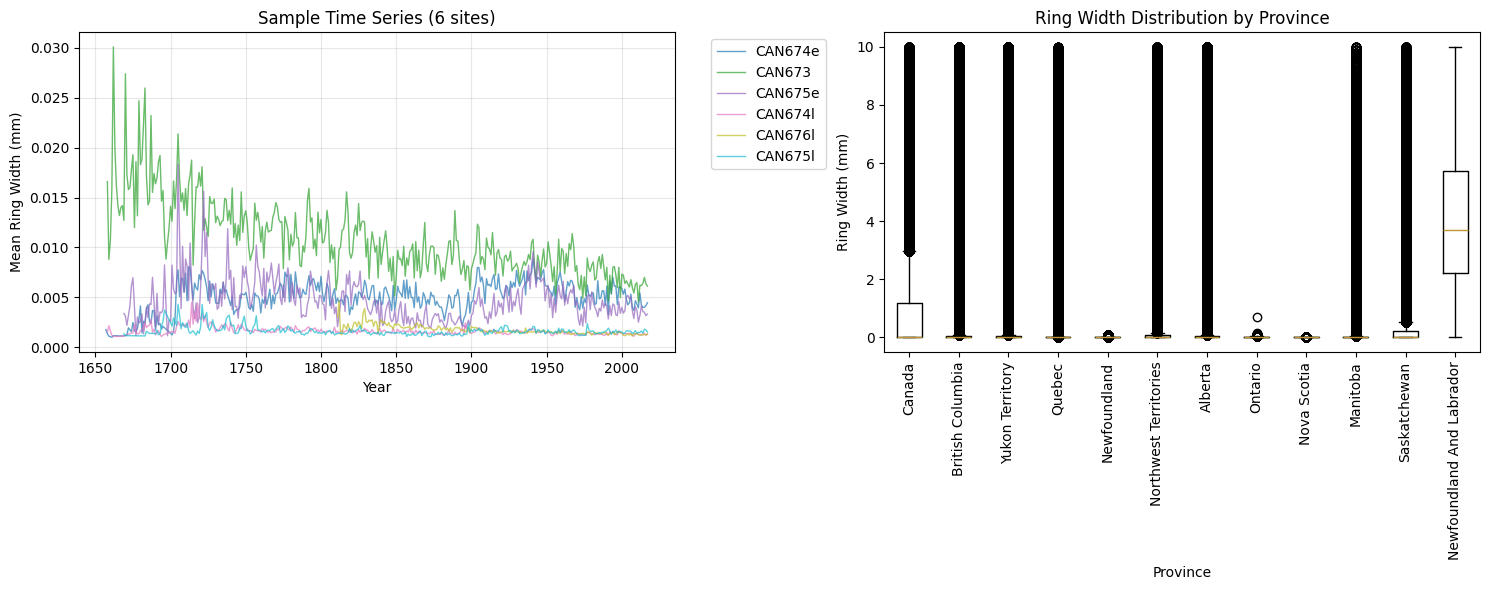

In [13]:
# 1. Geographic distribution of sites
if coords_df is not None:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Map of coordinates
scatter = ax1.scatter(coords_df['lon'], coords_df['lat'], 
                    alpha=0.6, s=30, c='red')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude') 
ax1.set_title('Geographic Distribution of Tree Ring Sites')
ax1.grid(True, alpha=0.3)

# Province distribution
if 'location' in coords_df.columns:
    province_counts = coords_df['location'].value_counts()
    ax2.bar(range(len(province_counts)), province_counts.values)
    ax2.set_xticks(range(len(province_counts)))
    ax2.set_xticklabels(province_counts.index, rotation=90)
    ax2.set_title('Sites by Province')
    ax2.set_ylabel('Number of Sites')

# Elevation distribution
if 'elevation_m' in coords_df.columns:
    elevation_data = pd.to_numeric(coords_df['elevation_m'], errors='coerce')
    valid_elevations = elevation_data.dropna()
    ax3.hist(valid_elevations, bins=30, alpha=0.7, color='green')
    ax3.set_xlabel('Elevation (m)')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Elevation Distribution')

# Time span distribution
if 'year_start' in coords_df.columns and 'year_end' in coords_df.columns:
    year_start = pd.to_numeric(coords_df['year_start'], errors='coerce')
    year_end = pd.to_numeric(coords_df['year_end'], errors='coerce')
    time_spans = year_end - year_start
    valid_spans = time_spans.dropna()
    ax4.hist(valid_spans, bins=30, alpha=0.7, color='blue')
    ax4.set_xlabel('Time Span (years)')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Record Length Distribution')

plt.tight_layout()
plt.show()

# 2. Data quality plots
if clean_file is not None:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Year distribution
ax1.hist(clean_file['year'], bins=50, alpha=0.7, color='orange')
ax1.set_xlabel('Year')
ax1.set_ylabel('Frequency')
ax1.set_title('Year Distribution (showing data quality issues)')
ax1.axvline(0, color='red', linestyle='--', label='Year 0')
ax1.axvline(2025, color='red', linestyle='--', label='Present')
ax1.legend()

# Ring width distribution
ax2.hist(clean_file['ring_width_mm'], bins=50, alpha=0.7, color='brown')
ax2.set_xlabel('Ring Width (mm)')
ax2.set_ylabel('Frequency')
ax2.set_title('Ring Width Distribution')

# Ring width vs year (problematic data highlighted)
valid_data = clean_file[
    (clean_file['year'] >= 1000) & 
    (clean_file['year'] <= 2025) &
    (clean_file['ring_width_mm'] > 0) &
    (clean_file['ring_width_mm'] <= 10)
]
problematic_data = clean_file[
    (clean_file['year'] < 1000) | 
    (clean_file['year'] > 2025) |
    (clean_file['ring_width_mm'] <= 0) |
    (clean_file['ring_width_mm'] > 10)
]

ax3.scatter(valid_data['year'], valid_data['ring_width_mm'], 
        alpha=0.5, s=1, color='green', label='Valid data')
if len(problematic_data) > 0:
    ax3.scatter(problematic_data['year'], problematic_data['ring_width_mm'], 
            alpha=0.7, s=2, color='red', label='Problematic data')
ax3.set_xlabel('Year')
ax3.set_ylabel('Ring Width (mm)')
ax3.set_title('Ring Width vs Year (Quality Check)')
ax3.legend()

# Species distribution from sample
if 'species_code' in clean_file.columns:
    species_counts = clean_file['species_code'].value_counts().head(15)
    ax4.barh(range(len(species_counts)), species_counts.values)
    ax4.set_yticks(range(len(species_counts)))
    ax4.set_yticklabels(species_counts.index)
    ax4.set_xlabel('Number of Measurements')
    ax4.set_title('Top 15 Species in Sample')

plt.tight_layout()
plt.show()

# 3. Clean data preview
if clean_file is not None:
    # Create cleaned sample
    clean_sample = clean_file[
        (clean_file['year'] >= 1000) & 
        (clean_file['year'] <= 2025) &
        (clean_file['ring_width_mm'] > 0) &
        (clean_file['ring_width_mm'] <= 10)
    ]
    
    if len(clean_sample) > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Time series for a few sites
        sample_sites = clean_sample['site_code'].unique()[:6]
        colors = plt.cm.tab10(np.linspace(0, 1, len(sample_sites)))
        
        for i, site in enumerate(sample_sites):
            site_data = clean_sample[clean_sample['site_code'] == site]
            site_annual = site_data.groupby('year')['ring_width_mm'].mean()
            ax1.plot(site_annual.index, site_annual.values, 
                    color=colors[i], alpha=0.7, linewidth=1, label=site)
        
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Mean Ring Width (mm)')
        ax1.set_title('Sample Time Series (6 sites)')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True, alpha=0.3)
        
        # Ring width by province
        if 'location' in clean_sample.columns:
            province_widths = []
            province_names = []
            for province in clean_sample['location'].unique():
                if pd.notna(province):
                    widths = clean_sample[clean_sample['location'] == province]['ring_width_mm']
                    if len(widths) > 10:  # Only include provinces with enough data
                        province_widths.append(widths)
                        province_names.append(province)
            
            if province_widths:
                ax2.boxplot(province_widths, labels=province_names)
                ax2.set_xlabel('Province')
                ax2.set_ylabel('Ring Width (mm)')
                ax2.set_title('Ring Width Distribution by Province')
                ax2.tick_params(axis='x', rotation=90)
        
        plt.tight_layout()
        plt.show()